# **DATA DECOMPRESSION**

Extracting data from r/food data dump found on https://the-eye.eu/redarcs/

In [ ]:
#installing libraries
!pip install zstandard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 27.0 MB/s eta 0:00:00


The following script was adapted from the code found here: https://github.com/Watchful1/PushshiftDumps/blob/master/scripts/to_csv.py

In [ ]:
#importing libraries
import zstandard
import os
import json
import csv
from datetime import datetime
import logging.handlers
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Paths to input and output files in Google Drive
input_file_path = r"/content/gdrive/MyDrive/dati_sna/food_submissions.zst"
output_file_path = r"/content/gdrive/MyDrive/dati_sna/submissions.csv"

# If you want a custom set of fields, put them in the following list. If you leave it empty, the script will use a default set of fields.
fields = ["author", "id" , "title" , "score" , "created"]

log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())

#function for reading and decoding
def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)

#function that opens and reads the zst file
def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2**27, (2**29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")

            for line in lines[:-1]:
                yield line, file_handle.tell()

            buffer = lines[-1]
        reader.close()

if __name__ == "__main__":
    if not fields:
        #default list of fields
        fields = ["author", "score", "created", "link", "body"]

    file_size = os.stat(input_file_path).st_size
    file_lines, bad_lines = 0, 0
    created = None

    #writing the csv file out of the zst
    with open(output_file_path, "w", encoding='utf-8', newline="") as output_file:
        writer = csv.writer(output_file)
        writer.writerow(fields)

        try:
            for line, file_bytes_processed in read_lines_zst(input_file_path):
                try:
                    obj = json.loads(line)
                    output_obj = []
                    for field in fields:
                        if field == "created":
                            value = datetime.fromtimestamp(int(obj['created_utc'])).strftime("%Y-%m-%d %H:%M")
                        elif field == "link":
                            if 'permalink' in obj:
                                value = f"https://www.reddit.com{obj['permalink']}"
                            else:
                                value = f"https://www.reddit.com/r/{obj['subreddit']}/comments/{obj['link_id'][3:]}/_/{obj['id']}/"
                        elif field == "author":
                            value = f"u/{obj['author']}"
                        elif field == "text":
                            value = obj.get('selftext', "")
                        else:
                            value = obj.get(field, "")

                        output_obj.append(str(value).encode("utf-8", errors='replace').decode())
                    writer.writerow(output_obj)

                    created = datetime.utcfromtimestamp(int(obj['created_utc']))
                except json.JSONDecodeError as err:
                    bad_lines += 1
                file_lines += 1
                if file_lines % 100000 == 0:
                    log.info(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {(file_bytes_processed / file_size) * 100:.0f}%")
        except KeyError as err:
            log.info(f"Object has no key: {err}")
            log.info(line)
        except Exception as err:
            log.info(err)
            log.info(line)

    log.info(f"Complete : {file_lines:,} : {bad_lines:,}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


2012-10-18 02:44:44 : 100,000 : 0 : 5%
2012-10-18 02:44:44 : 100,000 : 0 : 5%
2012-10-18 02:44:44 : 100,000 : 0 : 5%
2012-10-18 02:44:44 : 100,000 : 0 : 5%
2012-10-18 02:44:44 : 100,000 : 0 : 5%
2012-10-18 02:44:44 : 100,000 : 0 : 5%
INFO:bot:2012-10-18 02:44:44 : 100,000 : 0 : 5%
2014-09-26 06:02:35 : 200,000 : 0 : 10%
2014-09-26 06:02:35 : 200,000 : 0 : 10%
2014-09-26 06:02:35 : 200,000 : 0 : 10%
2014-09-26 06:02:35 : 200,000 : 0 : 10%
2014-09-26 06:02:35 : 200,000 : 0 : 10%
2014-09-26 06:02:35 : 200,000 : 0 : 10%
INFO:bot:2014-09-26 06:02:35 : 200,000 : 0 : 10%
2015-10-08 03:03:06 : 300,000 : 0 : 16%
2015-10-08 03:03:06 : 300,000 : 0 : 16%
2015-10-08 03:03:06 : 300,000 : 0 : 16%
2015-10-08 03:03:06 : 300,000 : 0 : 16%
2015-10-08 03:03:06 : 300,000 : 0 : 16%
2015-10-08 03:03:06 : 300,000 : 0 : 16%
INFO:bot:2015-10-08 03:03:06 : 300,000 : 0 : 16%
2016-08-17 19:21:22 : 400,000 : 0 : 21%
2016-08-17 19:21:22 : 400,000 : 0 : 21%
2016-08-17 19:21:22 : 400,000 : 0 : 21%
2016-08-17 19:21:22 

**Decompressione commenti** (similarly as submissions)

In [ ]:
#import libraries
import zstandard
import os
import json
import csv
from datetime import datetime
import logging.handlers
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Paths to input and output files in Google Drive
input_file_path = r"/content/gdrive/MyDrive/dati_sna/food_comments.zst"
output_file_path = r"/content/gdrive/MyDrive/dati_sna/comments.csv"

# If you want a custom set of fields, put them in the following list. If you leave it empty, the script will use a default set of fields.
fields = ["author","parent_id", "id", "body", "score", "created"]

log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())

#function for reading and decoding
def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)

#function that opens and reads the zst file
def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2**27, (2**29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")

            for line in lines[:-1]:
                yield line, file_handle.tell()

            buffer = lines[-1]
        reader.close()

if __name__ == "__main__":
    if not fields:
        #default list of fields
        fields = ["author", "score", "created", "link", "body"]

    file_size = os.stat(input_file_path).st_size
    file_lines, bad_lines = 0, 0
    created = None

    #writing the csv file out of the zst
    with open(output_file_path, "w", encoding='utf-8', newline="") as output_file:
        writer = csv.writer(output_file)
        writer.writerow(fields)

        try:
            for line, file_bytes_processed in read_lines_zst(input_file_path):
                try:
                    obj = json.loads(line)
                    output_obj = []
                    for field in fields:
                        if field == "created":
                            value = datetime.fromtimestamp(int(obj['created_utc'])).strftime("%Y-%m-%d %H:%M")
                        elif field == "link":
                            if 'permalink' in obj:
                                value = f"https://www.reddit.com{obj['permalink']}"
                            else:
                                value = f"https://www.reddit.com/r/{obj['subreddit']}/comments/{obj['link_id'][3:]}/_/{obj['id']}/"
                        elif field == "author":
                            value = f"u/{obj['author']}"
                        elif field == "text":
                            value = obj.get('selftext', "")
                        else:
                            value = obj.get(field, "")

                        output_obj.append(str(value).encode("utf-8", errors='replace').decode())
                    writer.writerow(output_obj)

                    created = datetime.utcfromtimestamp(int(obj['created_utc']))
                except json.JSONDecodeError as err:
                    bad_lines += 1
                file_lines += 1
                if file_lines % 100000 == 0:
                    log.info(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {(file_bytes_processed / file_size) * 100:.0f}%")
        except KeyError as err:
            log.info(f"Object has no key: {err}")
            log.info(line)
        except Exception as err:
            log.info(err)
            log.info(line)

    log.info(f"Complete : {file_lines:,} : {bad_lines:,}")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


2010-04-26 19:29:27 : 100,000 : 0 : 4%
2010-04-26 19:29:27 : 100,000 : 0 : 4%
2010-04-26 19:29:27 : 100,000 : 0 : 4%
2010-04-26 19:29:27 : 100,000 : 0 : 4%
2010-04-26 19:29:27 : 100,000 : 0 : 4%
2010-04-26 19:29:27 : 100,000 : 0 : 4%
2010-04-26 19:29:27 : 100,000 : 0 : 4%
2010-04-26 19:29:27 : 100,000 : 0 : 4%
2010-04-26 19:29:27 : 100,000 : 0 : 4%
INFO:bot:2010-04-26 19:29:27 : 100,000 : 0 : 4%
2010-11-05 15:11:39 : 200,000 : 0 : 4%
2010-11-05 15:11:39 : 200,000 : 0 : 4%
2010-11-05 15:11:39 : 200,000 : 0 : 4%
2010-11-05 15:11:39 : 200,000 : 0 : 4%
2010-11-05 15:11:39 : 200,000 : 0 : 4%
2010-11-05 15:11:39 : 200,000 : 0 : 4%
2010-11-05 15:11:39 : 200,000 : 0 : 4%
2010-11-05 15:11:39 : 200,000 : 0 : 4%
2010-11-05 15:11:39 : 200,000 : 0 : 4%
INFO:bot:2010-11-05 15:11:39 : 200,000 : 0 : 4%
2011-03-21 02:45:44 : 300,000 : 0 : 7%
2011-03-21 02:45:44 : 300,000 : 0 : 7%
2011-03-21 02:45:44 : 300,000 : 0 : 7%
2011-03-21 02:45:44 : 300,000 : 0 : 7%
2011-03-21 02:45:44 : 300,000 : 0 : 7%
2011-03

# **EDGELIST CREATION**

In [ ]:
# deleting old posts/comments to reach a comfortable data size

# to execute this cell, the last column of the input CSV file must be the field "created"

import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

def delete_rows(input_file, output_file):
    df = pd.read_csv(input_file)
    # converting last column in datetime
    df['created'] = pd.to_datetime(df.iloc[:, -1])
    # filtering rows by creation time
    # time range is 2008-01-26 22:40:00 / 2022-12-31 23:48:00
    df_filtered = df[df['created'] >= '2022-01-01']
    # save a new CSV
    df_filtered.to_csv(output_file, index=False)
    print("CSV file is now filtered!")


# deleting old posts
input_file = r'/content/gdrive/MyDrive/dati_sna/submissions.csv'
output_file =r'/content/gdrive/MyDrive/dati_sna/submissions_decimato_2022.csv'
delete_rows(input_file, output_file)

# deleting old comments
input_file = r'/content/gdrive/MyDrive/dati_sna/comments.csv'
output_file =r'/content/gdrive/MyDrive/dati_sna/comments_decimato_2022.csv'
delete_rows(input_file, output_file)

Mounted at /content/gdrive
CSV file is now filtered!
CSV file is now filtered!


In [ ]:
# creating the edgelist (+- 31 min)

# each node is a user that has posted at least one time in 2022

# edges are defined as interaction in terms of comments under posts only

import csv
from google.colab import drive

drive.mount('/content/gdrive')

# input and output files
input_file       = r"/content/gdrive/MyDrive/dati_sna/comments_decimato_2022.csv"
submissions_file = r"/content/gdrive/MyDrive/dati_sna/submissions_decimato_2022.csv"
output_file      = r"/content/gdrive/MyDrive/dati_sna/edgelist_2022.csv"

# loading input file's rows (comments)
rows = []
with open(input_file, mode='r') as file:
    csvreader = csv.reader(file)
    next(csvreader)  # skipping first row
    for row in csvreader:
        # discarding deleted users
        if row[0] != 'u/[deleted]':
            rows.append(row)

# loading sumbissions into a dictionary id-author
sub_rows = []
submissions_dict = {}
with open(submissions_file, mode='r') as file:
    csvreader = csv.reader(file)
    next(csvreader) # skipping first row
    for row in csvreader:
        # discarding deleted users
        if row[0] != 'u/[deleted]':
            author, sub_id , title, score , created= row
            submissions_dict[sub_id] = author
            sub_rows.append(row)

# list of couples of authors
author_pairs = set()
i=0

# check if id (of submissions) == parent_id_trimmed (of comments), this means A has commented B's post
for row in rows:
    if len(row) == 6:
      author, parent_id, comment_id , body, score , created= row
      parent_id_trimmed = parent_id[3:] if len(parent_id) > 3 else parent_id

    # if id == parent_id_trimmed we add the two authors to a list
    if parent_id_trimmed in submissions_dict:
        author_submission = submissions_dict[parent_id_trimmed]
        if i%1000 == 0:
            print(i, "confronti fatti")
        i+=1
        if author in submissions_dict.values():
            author_pairs.add((author, author_submission))



# Writing the result in a CSV file
with open(output_file, mode='w', newline='') as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(['author1', 'author2'])
    for pair in author_pairs:
        csvwriter.writerow(pair)

print(f"author couples written in: {output_file}")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
0 confronti fatti
1000 confronti fatti
2000 confronti fatti
3000 confronti fatti
4000 confronti fatti
5000 confronti fatti
6000 confronti fatti
7000 confronti fatti
8000 confronti fatti
9000 confronti fatti
10000 confronti fatti
11000 confronti fatti
12000 confronti fatti
13000 confronti fatti
14000 confronti fatti
15000 confronti fatti
16000 confronti fatti
17000 confronti fatti
19000 confronti fatti
20000 confronti fatti
21000 confronti fatti
22000 confronti fatti
23000 confronti fatti
24000 confronti fatti
25000 confronti fatti
26000 confronti fatti
27000 confronti fatti
28000 confronti fatti
29000 confronti fatti
30000 confronti fatti
31000 confronti fatti
32000 confronti fatti
33000 confronti fatti
34000 confronti fatti
35000 confronti fatti
36000 confronti fatti
37000 confronti fatti
38000 confronti fatti
39000 confronti fatti
40000 confronti fatti
41

# **NETWORK ANALYSIS**

## Graph Creation

In [ ]:
%%capture

# installing libraries

!pip install networkx
!pip install powerlaw

Reading the edgelist file in order to create the network

In [ ]:
%%capture
# importing libraries
import networkx as nx
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from google.colab import drive
warnings.filterwarnings('ignore')

# loading the edgelist from the cloud
drive.mount('/content/gdrive')
%matplotlib inline
df=pd.read_csv("/content/gdrive/MyDrive/dati_sna/edgelist_2022.csv")

# create the unweighted undirected graph (used in the network analysis)
df_unweighted = df[['author1', 'author2']].drop_duplicates()
graph = nx.from_pandas_edgelist(df_unweighted, 'author1', 'author2')

Creating synthetic graphs for comparison

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Set seed for reproducibility
random.seed(42)

# Number of nodes and edges
n_nodes = graph.number_of_nodes()
n_links = graph.number_of_edges()

# Calculate the probability for the Erdős–Rényi graph
p_er = n_links / (n_nodes * (n_nodes - 1) / 2)

# Calculate "m" for the Barabási–Albert graph
m_ba = n_links // n_nodes

# Create the Erdős–Rényi graph
er_graph = nx.erdos_renyi_graph(n_nodes, p_er, seed=42)

# Create the Barabási–Albert graph
ba_graph = nx.barabasi_albert_graph(n_nodes, m_ba, seed=42)

print("p_er: ",p_er)
print("m_ba: ",m_ba)


p_er:  0.0003249247615790506
m_ba:  3


## Degree Distribution Analysis

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


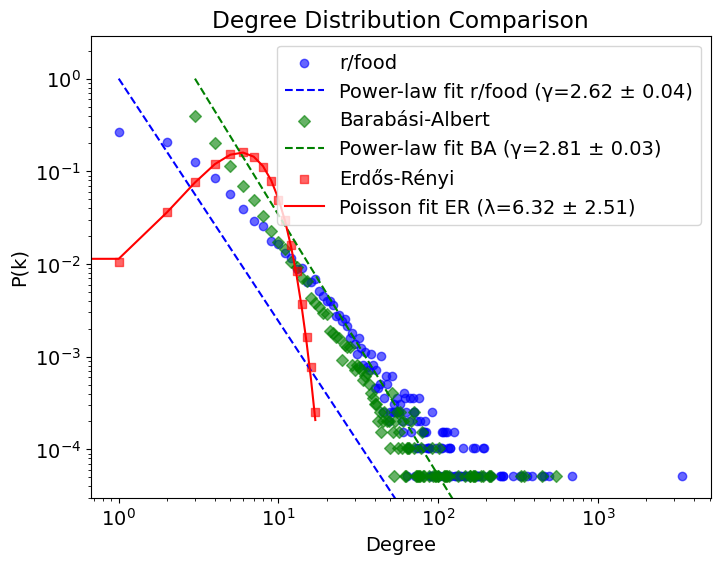

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from scipy.stats import poisson

# Increase font size globally
plt.rcParams.update({'font.size': 14})

# Get node degrees
degrees_graph = np.array([d for _, d in graph.degree()])
degrees_er = np.array([d for _, d in er_graph.degree()])
degrees_ba = np.array([d for _, d in ba_graph.degree()])

# Fit power-law distribution for r/food and Barabási-Albert
fit_graph = powerlaw.Fit(degrees_graph, discrete=True)
fit_ba = powerlaw.Fit(degrees_ba, discrete=True)

# Fit Poisson distribution for Erdős-Rényi
lambda_er = np.mean(degrees_er)
sigma_er = np.sqrt(lambda_er)  # Poisson standard deviation
k_values = np.arange(0, max(degrees_er) + 1)
poisson_fit = poisson.pmf(k_values, lambda_er) * len(degrees_er)

# Count the frequency of each degree
def degree_distribution(degrees):
    degree_counts = np.bincount(degrees)
    nonzero_indices = np.nonzero(degree_counts)[0]
    degree_frequencies = degree_counts[nonzero_indices] / len(degrees)
    return nonzero_indices, degree_frequencies

indices_graph, freq_graph = degree_distribution(degrees_graph)
indices_er, freq_er = degree_distribution(degrees_er)
indices_ba, freq_ba = degree_distribution(degrees_ba)

# Creating one unique plot
plt.figure(figsize=(8, 6))

# Plot r/food
plt.scatter(indices_graph, freq_graph, color='b', alpha=0.6, label='r/food', marker='o')
x_fit_graph = np.linspace(min(indices_graph), max(indices_graph), 100)
plt.plot(x_fit_graph, x_fit_graph**-fit_graph.alpha / max(x_fit_graph**-fit_graph.alpha), 'b--',
         label=f'Power-law fit r/food (γ={fit_graph.alpha:.2f} ± {fit_graph.sigma:.2f})')

# Plot Barabási-Albert
plt.scatter(indices_ba, freq_ba, color='g', alpha=0.6, label='Barabási-Albert', marker='D')
x_fit_ba = np.linspace(min(indices_ba), max(indices_ba), 100)
plt.plot(x_fit_ba, x_fit_ba**-fit_ba.alpha / max(x_fit_ba**-fit_ba.alpha), 'g--',
         label=f'Power-law fit BA (γ={fit_ba.alpha:.2f} ± {fit_ba.sigma:.2f})')

# Plot Erdős-Rényi
plt.scatter(indices_er, freq_er, color='r', alpha=0.6, label='Erdős-Rényi', marker='s')
plt.plot(k_values, poisson_fit / len(degrees_er), 'r-',
         label=f'Poisson fit ER (λ={lambda_er:.2f} ± {sigma_er:.2f})')

# General settings
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.00003, None)
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.title('Degree Distribution Comparison')
plt.legend()

# Showing the plot
plt.show()

Which is the Erdos Renyi graph regime?

In [ ]:
degrees = [deg for _, deg in er_graph.degree() ]
if np.mean(degrees)<1:
  print("Subcritical")
if np.mean(degrees)==1:
  print("Critical")
if np.mean(degrees)>1 and np.mean(degrees)<= np.log(er_graph.number_of_nodes()):
  print("Supercritical")
if np.mean(degrees)> np.log(er_graph.number_of_nodes()):
  print("Connected")

Supercritical


## Connected Components Analysis

In [ ]:
def components_analysis(g):

    print(f"Is graph connected? {nx.is_connected(g)}")
    num_components = nx.number_connected_components(g)
    print(f"Number of connected components: {num_components}")
    components = list(nx.connected_components(g))

    # Considering the largest connected component
    largest_component = max(components, key=len)
    subgraph = g.subgraph(largest_component)

    # Compute the fraction of nodes in the largest component
    print(f"Fraction of nodes in largest component: {len(largest_component)*100 / g.number_of_nodes():.4f} %")


In [ ]:
print("\nOur graph")
components_analysis(graph)
print("\nErdos Renyi")
components_analysis(er_graph)
print("\nBarabasi Albert")
components_analysis(ba_graph)


Our graph
Is graph connected? False
Number of connected components: 1496
Fraction of nodes in largest component: 91.8973 %

Erdos Renyi
Is graph connected? False
Number of connected components: 38
Fraction of nodes in largest component: 99.8107 %

Barabasi Albert
Is graph connected? True
Number of connected components: 1
Fraction of nodes in largest component: 100.0000 %


## Path Analysis

In [ ]:
%%capture
!pip install igraph

In [ ]:
import igraph as ig
import matplotlib.pyplot as plt

def path_analysis(G):
    # Conversion from networkx to igraph
    G_ig = ig.Graph.from_networkx(G)

    # Computing Diameter
    diam = G_ig.diameter()
    print("Diameter:", diam)

    # Computing Average Shortest Path Length
    asp_igraph = G_ig.average_path_length()
    print("Average Shortest Path Length:", asp_igraph)

In [ ]:
print("\nOur graph")
path_analysis(graph)
print("\nErdos Renyi")
path_analysis(er_graph)
print("\nBarabasi Albert")
path_analysis(ba_graph)


Our graph
Diameter: 11
Average Shortest Path Length: 3.863859387124545

Erdos Renyi
Diameter: 10
Average Shortest Path Length: 5.564687114504788

Barabasi Albert
Diameter: 7
Average Shortest Path Length: 4.463955699070098


Path Lenght Distribution

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import Counter

# Path length distribution function (as defined before)
def plot_path_length_distribution(graph, num_samples=10000):
    sampled_nodes = random.sample(list(graph.nodes), min(num_samples, len(graph.nodes)))

    def sampled_shortest_paths(graph, sampled_nodes):
        path_lengths = []
        for node in sampled_nodes:
            lengths = nx.single_source_dijkstra_path_length(graph, node)
            for target, length in lengths.items():
                if node != target:
                    path_lengths.append(length)
        return path_lengths

    lengths = sampled_shortest_paths(graph, sampled_nodes)
    length_counts = Counter(lengths)
    total_paths = sum(length_counts.values())

    x_values = list(length_counts.keys())
    y_values = [count / total_paths for count in length_counts.values()]

    return x_values, y_values

# Compute the path length distributions for each graph
x_values_1, y_values_1 = plot_path_length_distribution(graph)
x_values_2, y_values_2 = plot_path_length_distribution(er_graph)
x_values_3, y_values_3 = plot_path_length_distribution(ba_graph)

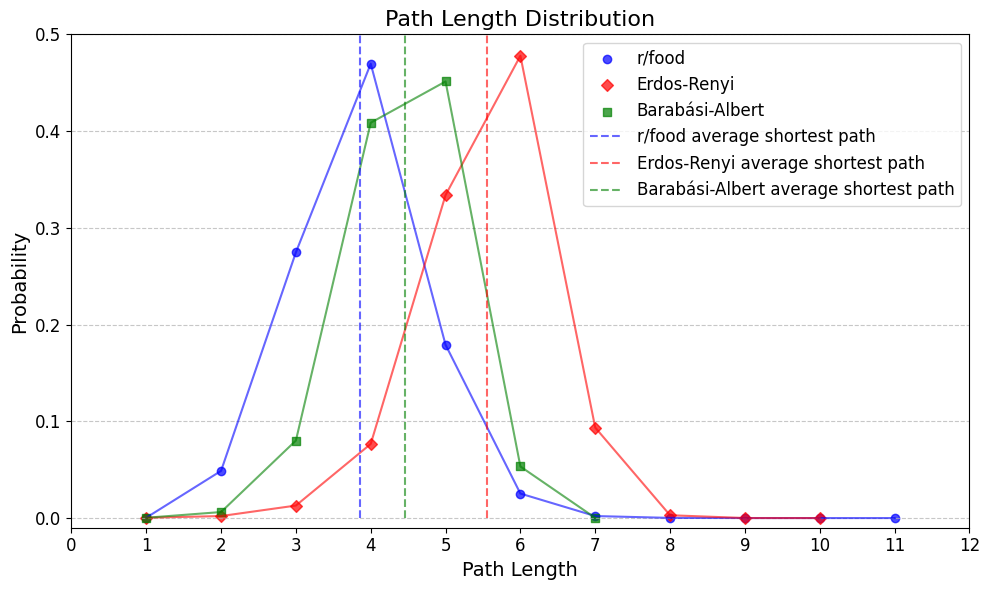

In [ ]:
# Create a single plot with different colors for each graph
plt.figure(figsize=(10, 6))

# Plot the three graphs with different colors
plt.scatter(x_values_1, y_values_1, color='b', alpha=0.7, label='r/food', marker='o')
plt.plot(x_values_1, y_values_1, linestyle='-', color='b', alpha=0.6)

plt.scatter(x_values_2, y_values_2, color='r', alpha=0.7, label='Erdos-Renyi', marker='D')
plt.plot(x_values_2, y_values_2, linestyle='-', color='r', alpha=0.6)

plt.scatter(x_values_3, y_values_3, color='g', alpha=0.7, label='Barabási-Albert', marker='s')
plt.plot(x_values_3, y_values_3, linestyle='-', color='g', alpha=0.6)

np.linspace(0, 0.5, 100)
plt.plot(3.86*np.ones(100), np.linspace(0, 0.5, 100), linestyle='--', color='b', alpha=0.6, label='r/food average shortest path')
plt.plot(5.56*np.ones(100), np.linspace(0, 0.5, 100), linestyle='--', color='r', alpha=0.6, label='Erdos-Renyi average shortest path')
plt.plot(4.46*np.ones(100), np.linspace(0, 0.5, 100), linestyle='--', color='g', alpha=0.6, label='Barabási-Albert average shortest path')

# Labels and title with enlarged font
plt.xlabel("Path Length", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.xticks(range(0, 13), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-0.01, 12)
plt.ylim(-0.01, 0.5)
plt.title("Path Length Distribution", fontsize=16)
plt.legend(fontsize=12)  # Adds a legend to identify the colors

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Clustering Coefficient, Density Analysis

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Function for fitting the power-law equation
def power_law(x, a, b):
    return a * x**b

def clustering_analysis(G):
    # Compute the average clustering coefficient and density
    average_clustering = nx.average_clustering(G)
    density = nx.density(G)
    print("Average Clustering Coefficient:", average_clustering)
    print("Density:", density)

    # Compute the clustering coefficient for each node
    clustering_coeffs = nx.clustering(G)

    # Compute the degree of nodes
    degrees = dict(G.degree())

    # Extract degrees and clustering coefficients (excluding nodes with C(k) = 0)
    degree_values = []
    clustering_values = []

    for node in G.nodes():
        if clustering_coeffs[node] > 0:  # Consider only nodes with clustering coefficient > 0
            degree_values.append(degrees[node])
            clustering_values.append(clustering_coeffs[node])

    degree_values = np.array(degree_values)
    clustering_values = np.array(clustering_values)

    # Fit the power-law equation to the data
    popt, _ = curve_fit(power_law, degree_values, clustering_values, maxfev=10000)
    a, b = popt  # Power-law parameters

    # Scatter plot of clustering coefficient vs node degree
    plt.figure(figsize=(8, 5))
    plt.scatter(degree_values, clustering_values, alpha=0.6, color='b', edgecolors='black', label='Data')

    # Plot the power-law fit
    x_fit = np.linspace(min(degree_values), max(degree_values), 100)
    y_fit = power_law(x_fit, *popt)
    plt.plot(x_fit, y_fit, linestyle='-', color='r', label=f'Power Law Fit: $y = {a:.2f} x^{b:.2f}$')

    # Plot the average clustering coefficient as a reference
    plt.axhline(y=average_clustering, color='g', linestyle='--', label='Average Clustering Coefficient')

    plt.xscale("log")  # Logarithmic scale for better visualization
    plt.yscale("log")  # Logarithmic scale for better visualization
    plt.xlabel("Node Degree", fontsize=14)
    plt.ylabel("Clustering Coefficient", fontsize=14)
    plt.title("Clustering Coefficient vs Node Degree (r/food)", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    print(b)
    plt.show()


Our graph
Average Clustering Coefficient: 0.023402919242577005
Density: 0.0003249247615790506
-1.8089101559443264


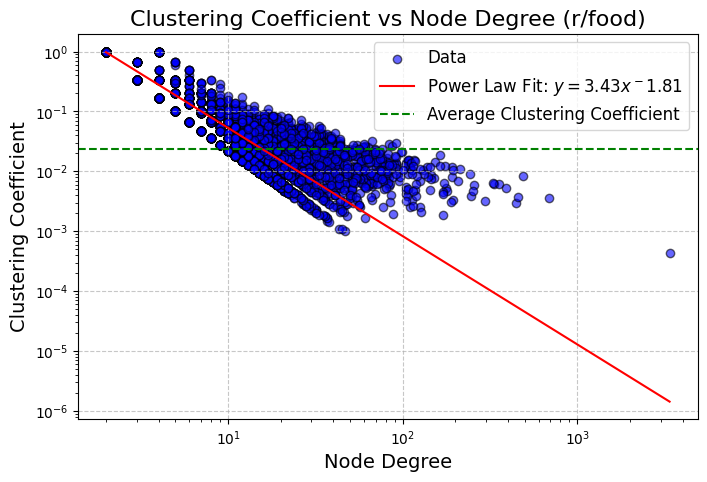


Erdos Renyi
Average Clustering Coefficient: 0.00036693999812317866
Density: 0.0003233128031587435
-2.2704024105479177


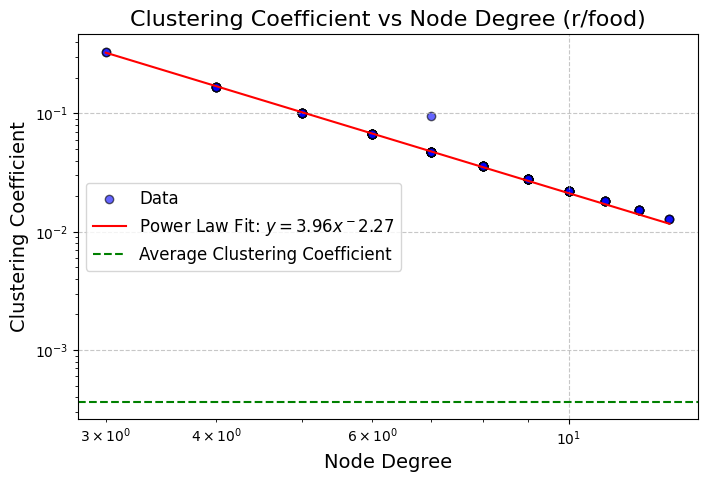


Barabasi Albert
Average Clustering Coefficient: 0.0036475471825712412
Density: 0.00030688966834405596
-2.3655217959902775


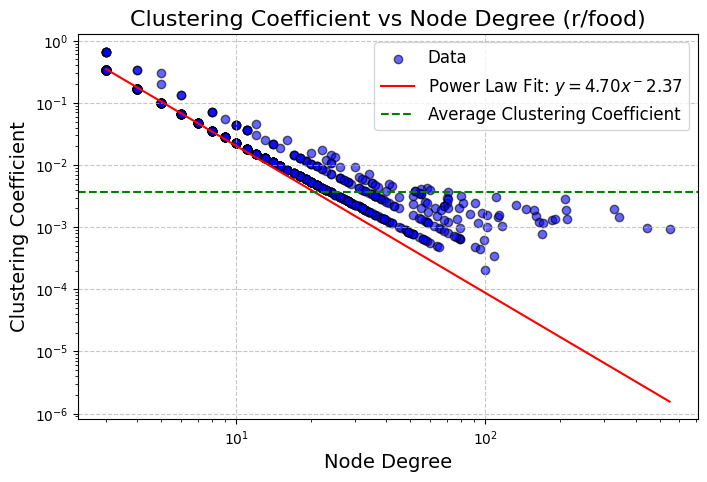

In [ ]:
print("\nOur graph")
clustering_analysis(graph)
print("\nErdos Renyi")
clustering_analysis(er_graph)
print("\nBarabasi Albert")
clustering_analysis(ba_graph)

## Centrality Analysis

Degree centrality

In [ ]:
def degree_stats(G):

    # Degree Centrality stats
    avg_degree_centrality = np.mean(list(nx.degree_centrality(G).values()))
    print(f"Average degree centrality: {avg_degree_centrality}")
    max_degree_centrality = max(nx.degree_centrality(G).values())
    min_degree_centrality = min(nx.degree_centrality(G).values())
    print(f"Max degree centrality: {max_degree_centrality}")
    print(f"Min degree centrality: {min_degree_centrality}")

In [ ]:
print("\nOur graph")
degree_stats(graph)
print("\nErdos Renyi")
degree_stats(er_graph)
print("\nBarabasi Albert")
degree_stats(ba_graph)


Our graph
Average degree centrality: 0.00032492476157905056
Max degree centrality: 0.17254962144464908
Min degree centrality: 5.11561285041948e-05

Erdos Renyi
Average degree centrality: 0.0003233128031587435
Max degree centrality: 0.0008696541845713117
Min degree centrality: 0.0

Barabasi Albert
Average degree centrality: 0.00030688966834405596
Max degree centrality: 0.02803355842029875
Min degree centrality: 0.0001534683855125844


Betweenness extended

In [ ]:
import networkx as nx

def betweenness_stats(G, k=1000): # Doing an approximation on k random samples

    betweenness = nx.betweenness_centrality(G, k=min(k, len(G)))  # Limiting k to the number of nodes if necessary
    values = list(betweenness.values())
    print(f"Min betweenness: {min(values)}")
    print(f"Max betweenness: {max(values)}")
    print(f"Avg betweenness: {sum(values) / len(values)}")
    return

In [ ]:
print("\nOur graph")
print(betweenness_stats(graph))
print("\nErdos Renyi")
print(betweenness_stats(er_graph))
print("\nBarabasi Albert")
print(betweenness_stats(ba_graph))


Our graph
Min betweenness: 0.0
Max betweenness: 0.3085400869497442
Avg betweenness: 0.00012413383569609526
None

Erdos Renyi
Min betweenness: 0.0
Max betweenness: 0.002179535169049213
Avg betweenness: 0.0002325384246198715
None

Barabasi Albert
Min betweenness: 4.3813164738351583e-07
Max betweenness: 0.1346773778541336
Avg betweenness: 0.00017701818660430423
None


Closeness extended

In [ ]:
import networkx as nx

def closeness_stats(G):
    # Find the largest component
    largest_component = max(nx.connected_components(G), key=len)
    subgraph = G.subgraph(largest_component)

    # Compute the closeness centrality explicitly for each node in the largest component
    closeness = nx.closeness_centrality(subgraph)
    values = list(closeness.values())

    # Print the stats
    print(f"Min closeness: {min(values)}")
    print(f"Max closeness: {max(values)}")
    print(f"Avg closeness: {sum(values) / len(values)}")
    return


In [ ]:
# 2h 15 run
print("\nOur graph")
closeness_stats(graph)
print("\nErdos Renyi")
closeness_stats(er_graph)
print("\nBarabasi Albert")
closeness_stats(ba_graph)


Our graph
Min closeness: 0.13960536848076968
Max closeness: 0.44139761167624947
Avg closeness: 0.26338813440001396

Erdos Renyi
Min closeness: 0.13373591423792944
Max closeness: 0.20684208294461878
Avg closeness: 0.18012107581083894

Barabasi Albert
Min closeness: 0.1779533723565986
Max closeness: 0.35957619012581854
Avg closeness: 0.22564087953457637


Eigenvector Centrality Extended

In [ ]:
import networkx as nx

def eigenvector_stats(G: nx.Graph) -> dict:

    # Find the largest connected component
    largest_component = max(nx.connected_components(G), key=len, default=set())

    subgraph = G.subgraph(largest_component)

    try:
        # Compute eigenvector centrality using the power method
        eigenvector = nx.eigenvector_centrality(subgraph, max_iter=1000, tol=1e-6)
        values = list(eigenvector.values())

        # Compute statistics
        stats = {
            "min": min(values),
            "max": max(values),
            "avg": sum(values) / len(values)
        }

        # Print statistics
        print(f"✅ Min eigenvector centrality: {stats['min']}")
        print(f"✅ Max eigenvector centrality: {stats['max']}")
        print(f"✅ Avg eigenvector centrality: {stats['avg']}")

        return stats

    except nx.PowerIterationFailedConvergence:
        print("⚠️ The algorithm failed to converge. Try increasing `max_iter` or relaxing `tol`.")
        return {"min": None, "max": None, "avg": None}

In [ ]:
print("\nOur graph")
eigenvector_stats(graph)
print("\nErdos Renyi")
eigenvector_stats(er_graph)
print("\nBarabasi Albert")
eigenvector_stats(ba_graph)


Our graph
✅ Min eigenvector centrality: 4.627772703734689e-10
✅ Max eigenvector centrality: 0.6734369620269157
✅ Avg eigenvector centrality: 0.002855966980429947

Erdos Renyi
✅ Min eigenvector centrality: 0.00011775859410639195
✅ Max eigenvector centrality: 0.030251128635843477
✅ Avg eigenvector centrality: 0.00636977454384903

Barabasi Albert
✅ Min eigenvector centrality: 1.3724625026904688e-05
✅ Max eigenvector centrality: 0.5524151919239302
✅ Avg eigenvector centrality: 0.0023676779430530535


{'min': 1.3724625026904688e-05,
 'max': 0.5524151919239302,
 'avg': 0.0023676779430530535}

Page Rank

In [ ]:
import networkx as nx

def pagerank_stats(G: nx.Graph, alpha: float = 0.85) -> dict:
    if nx.number_of_nodes(G) == 0:
        print("❌ Empty graph. No statistics available.")
        return {"min": None, "max": None, "avg": None}

    # Find the largest connected component
    largest_component = max(nx.connected_components(G), key=len, default=set())

    if not largest_component:  # Case of a completely disconnected graph
        print("❌ The graph has no connected components.")
        return {"min": None, "max": None, "avg": None}

    subgraph = G.subgraph(largest_component)

    try:
        # Compute PageRank with damping factor and iterative method
        pagerank = nx.pagerank(subgraph, alpha=alpha, max_iter=10000, tol=1e-6)
        values = list(pagerank.values())

        # Compute statistics
        stats = {
            "min": min(values),
            "max": max(values),
            "avg": sum(values) / len(values)
        }

        # Print statistics
        print(f"✅ Min PageRank: {stats['min']}")
        print(f"✅ Max PageRank: {stats['max']}")
        print(f"✅ Avg PageRank: {stats['avg']}")

        return stats

    except nx.PowerIterationFailedConvergence:
        print("⚠️ The PageRank algorithm failed to converge. Try increasing `max_iter` or relaxing `tol`.")
        return {"min": None, "max": None, "avg": None}

In [ ]:
print("\nOur graph")
pagerank_stats(graph)
print("\nErdos Renyi")
pagerank_stats(er_graph)
print("\nBarabasi Albert")
pagerank_stats(ba_graph)


Our graph
✅ Min PageRank: 1.3900126026589943e-05
✅ Max PageRank: 0.03212558186517892
✅ Avg PageRank: 5.5663790704148586e-05

Erdos Renyi
✅ Min PageRank: 1.3964051799681806e-05
✅ Max PageRank: 0.00012571598995305837
✅ Avg PageRank: 5.125051250512469e-05

Barabasi Albert
✅ Min PageRank: 2.623392139387908e-05
✅ Max PageRank: 0.003966637500359874
✅ Avg PageRank: 5.1153511688577424e-05


{'min': 2.623392139387908e-05,
 'max': 0.003966637500359874,
 'avg': 5.1153511688577424e-05}

Katz Centrality

In [ ]:
import networkx as nx

def katz_stats(G: nx.Graph, alpha: float = 0.01, beta: float = 1.0) -> dict:
    if nx.number_of_nodes(G) == 0:
        print("❌ Empty graph. No statistics available.")
        return {"min": None, "max": None, "avg": None}

    # Find the largest connected component
    largest_component = max(nx.connected_components(G), key=len, default=set())

    if not largest_component:  # Case of a completely disconnected graph
        print("❌ The graph has no connected components.")
        return {"min": None, "max": None, "avg": None}

    subgraph = G.subgraph(largest_component)

    try:
        # Compute Katz Centrality using an iterative method
        katz = nx.katz_centrality(subgraph, alpha=alpha, beta=beta, max_iter=1000, tol=1e-6)
        values = list(katz.values())

        # Compute statistics
        stats = {
            "min": min(values),
            "max": max(values),
            "avg": sum(values) / len(values)
        }

        # Print statistics
        print(f"✅ Min Katz Centrality: {stats['min']}")
        print(f"✅ Max Katz Centrality: {stats['max']}")
        print(f"✅ Avg Katz Centrality: {stats['avg']}")

        return stats

    except nx.PowerIterationFailedConvergence:
        print("⚠️ The Katz algorithm failed to converge. Try increasing `max_iter` or reducing `alpha`.")
        return {"min": None, "max": None, "avg": None}

In [ ]:
print("\nOur graph")
katz_stats(graph)
print("\nErdos Renyi")
katz_stats(er_graph)
print("\nBarabasi Albert")
katz_stats(ba_graph)


Our graph
✅ Min Katz Centrality: 0.005520192846468815
✅ Max Katz Centrality: 0.3298593147290114
✅ Avg Katz Centrality: 0.006757260813624101

Erdos Renyi
✅ Min Katz Centrality: 0.006767255910507653
✅ Max Katz Centrality: 0.007944761582093384
✅ Avg Katz Centrality: 0.0071566222461900385

Barabasi Albert
✅ Min Katz Centrality: 0.006812941031857455
✅ Max Katz Centrality: 0.05072233836872744
✅ Avg Katz Centrality: 0.007108592078032518


{'min': 0.006812941031857455,
 'max': 0.05072233836872744,
 'avg': 0.007108592078032518}

## Other Stuff

Assortativity

In [ ]:
import networkx as nx

# Calculating assortativity and printing out the so obtained values
print("\nOur graph")
print(nx.degree_assortativity_coefficient(graph))
print("\nErdos Renyi")
print(nx.degree_assortativity_coefficient(er_graph))
print("\nBarabasi Albert")
print(nx.degree_assortativity_coefficient(ba_graph))


Our graph
-0.05199789425328658

Erdos Renyi
0.005584207771079946

Barabasi Albert
-0.029785627762207674


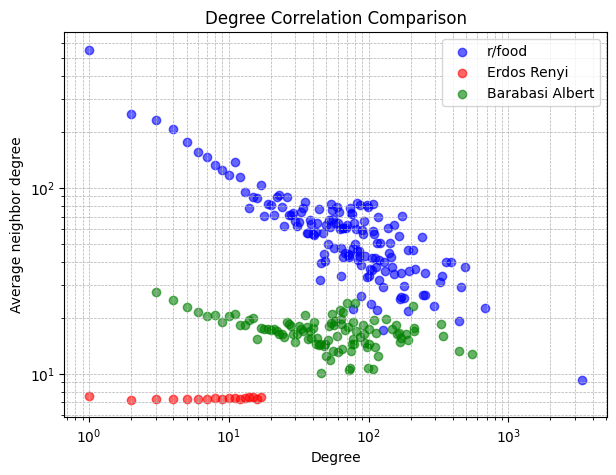

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def plot_degree_correlation(G, label, color):
    """Plots the degree correlation for a given graph."""
    knn = nx.average_degree_connectivity(G)

    x = np.array(list(knn.keys()))
    y = np.array(list(knn.values()))

    plt.scatter(x, y, color=color, alpha=0.6, label=label)

# Create the figure
plt.figure(figsize=(7, 5))

# Plot the three graphs with different colors
plot_degree_correlation(graph, "r/food", "b")
plot_degree_correlation(er_graph, "Erdos Renyi", "r")
plot_degree_correlation(ba_graph, "Barabasi Albert", "g")

# Customize the plot
plt.xlabel("Degree")
plt.ylabel("Average neighbor degree")
plt.title("Degree Correlation Comparison")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.show()